# Hòa phát group 80 - 20

## Huấn luyện model

### Xử lý dữ liệu

In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('HPG Historical Data.csv',sep=",")
df1 = df.reset_index()['Price']

# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))
train_data = df1[:train_size]
test_data = df1[train_size:]

# 5. Hàm Create Dataset (convert an array of values into a dataset matrix)
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
train_last_windowsize = train_data[-time_step-1:]
test_data_extended = np.concatenate((train_last_windowsize, test_data), axis=0)
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data_extended, time_step)


# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### Model  

In [2]:
# Define the RNN model
def create_rnn_model():
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create and train multiple GRU models
n_estimators = 10
predictions = []

for _ in range(n_estimators):
    base_model = create_rnn_model()
    base_model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)
    y_pred = base_model.predict(X_test)
    predictions.append(y_pred.flatten())

# Average the predictions
bagging_predictions = np.mean(predictions, axis=0)

# Inverse transform the predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
bagging_predictions_inv = scaler.inverse_transform(bagging_predictions.reshape(-1, 1))

c:\Users\hangt\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0154
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0020
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0011
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 8.8505e-04
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.5637e-04
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 7.6231e-04
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 7.5261e-04
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 7.0881e-04
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 6.5991e-04
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 6.7869e-04
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 5.8399e-04
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.1012e-04
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 6.2631e-04
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 6.4506e-04
Epoch 15/100

## Đánh giá model

In [ ]:
# 8. Dự đoán và đánh giá mô hình
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Inverse transform the true values for the testing data
true_values_testing = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE for testing data
test_mae = np.mean(abs(bagging_predictions_inv - true_values_testing))
print('Testing MAE:', test_mae)

# Calculate RMSE for testing data
rmse_testing = np.sqrt(mean_squared_error(true_values_testing, bagging_predictions_inv))
print(f'Testing RMSE: {rmse_testing}')

# Calculate MAPE for testing data
mape_testing = mean_absolute_percentage_error(true_values_testing, bagging_predictions_inv) * 100
print(f'Testing MAPE: {mape_testing}')

# Calculate MLSE for testing data
mlse_testing = np.mean((np.log1p(true_values_testing) - np.log1p(bagging_predictions_inv))**2)
print(f'Testing MLSE: {mlse_testing}')

# Calculate R-squared (R²) for testing data
r2_testing = r2_score(true_values_testing, bagging_predictions_inv)
print(f'Testing R²: {r2_testing}')

# Calculate Mean Squared Error (MSE) for testing data
mse_testing = mean_squared_error(true_values_testing, bagging_predictions_inv)
print(f'Testing MSE: {mse_testing}')

Testing MAE: 154.8489521447243
Testing RMSE: 209.13372387353226
Testing MAPE: 1.4640585855924537
Testing MLSE: 0.00039452409639931723
Testing R²: 0.9099613937337363
Testing MSE: 43736.914461210836


## Dự đoán

In [ ]:
# Create DataFrame for test predictions
test_predict_df = pd.DataFrame(bagging_predictions_inv, columns=['Adj Close'])
test_predict_index = range(len(train_data) + time_step, len(train_data) + time_step + len(bagging_predictions_inv))
test_predict_df.index = test_predict_index

# Create DataFrame for actual train and test data
train_data_df = pd.DataFrame(scaler.inverse_transform(train_data), columns=['Adj Close'])
test_data_df = pd.DataFrame(scaler.inverse_transform(test_data), columns=['Adj Close'])

# Predict the next 90 days
last_100_days = test_data[-time_step:].reshape(1, time_step, 1)
next_90_days = []

for _ in range(90):
    next_day = base_model.predict(last_100_days)
    next_90_days.append(next_day[0, 0])
    last_100_days = np.append(last_100_days[:, 1:, :], [[next_day[0]]], axis=1)

next_90_days_inv = scaler.inverse_transform(np.array(next_90_days).reshape(-1, 1))
next_90_days_index = np.arange(len(df), len(df) + 90)
next_90_days_df = pd.DataFrame(next_90_days_inv, index=next_90_days_index, columns=['Adj Close'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Plot the data
plt.figure(figsize=(12, 6))

# Plot the testing data
test_data_index = pd.RangeIndex(start=len(train_data), stop=len(train_data) + len(test_data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Plot test predictions
plt.plot(test_data_index, test_predict_df['Adj Close'])

# Plot next 90 days predictions
plt.plot(next_90_days_df.index[:30], next_90_days_df['Adj Close'][:30], label='Next 30 days')
plt.plot(next_90_days_df.index[30:60], next_90_days_df['Adj Close'][30:60], label='Next 60 days')
plt.plot(next_90_days_df.index[60:], next_90_days_df['Adj Close'][60:], label='Next 90 days')

# Add title and labels
plt.title('Stock Price Forecast for Hòa Phát Group Using Bagging Ensemble (80:20)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend(['Test', 'Test Predict', 'Predict 30days', 'Predict 60days', 'Predict 90days'])
plt.show()

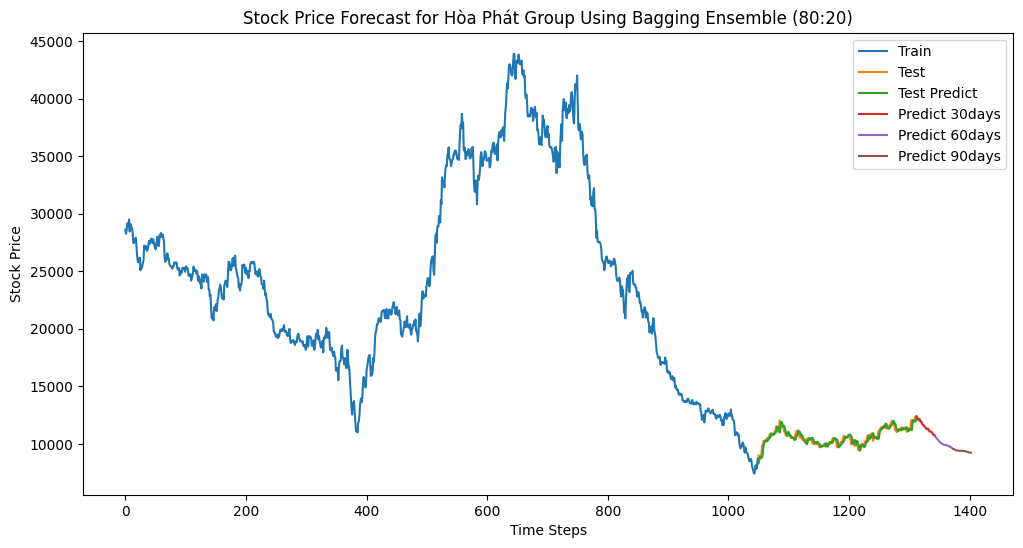

In [ ]:
# Plot the data
plt.figure(figsize=(12, 6))

# Plot the training data
train_data_index = pd.RangeIndex(start=0, stop=len(train_data), step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

# Plot the testing data
test_data_index = pd.RangeIndex(start=len(train_data), stop=len(train_data) + len(test_data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Plot test predictions
plt.plot(test_data_index, test_predict_df['Adj Close'])

# Plot next 90 days predictions
plt.plot(next_90_days_df.index[:30], next_90_days_df['Adj Close'][:30], label='Next 30 days')
plt.plot(next_90_days_df.index[30:60], next_90_days_df['Adj Close'][30:60], label='Next 60 days')
plt.plot(next_90_days_df.index[60:], next_90_days_df['Adj Close'][60:], label='Next 90 days')

# Add title and labels
plt.title('Stock Price Forecast for Hòa Phát Group Using Bagging Ensemble (80:20)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend(['Train', 'Test', 'Test Predict', 'Predict 30days', 'Predict 60days', 'Predict 90days'])
plt.show()

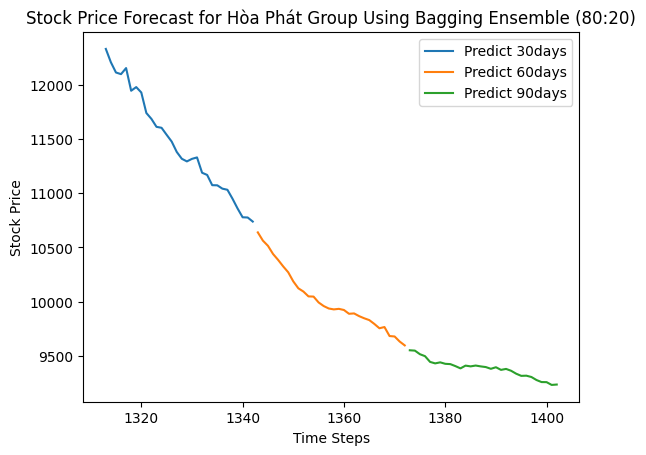

In [ ]:
# Plot next 90 days predictions
plt.plot(next_90_days_df.index[:30], next_90_days_df['Adj Close'][:30], label='Next 30 days')
plt.plot(next_90_days_df.index[30:60], next_90_days_df['Adj Close'][30:60], label='Next 60 days')
plt.plot(next_90_days_df.index[60:], next_90_days_df['Adj Close'][60:], label='Next 90 days')

# Add title and labels
plt.title('Stock Price Forecast for Hòa Phát Group Using Bagging Ensemble (80:20)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend([ 'Predict 30days', 'Predict 60days', 'Predict 90days'])
plt.show()

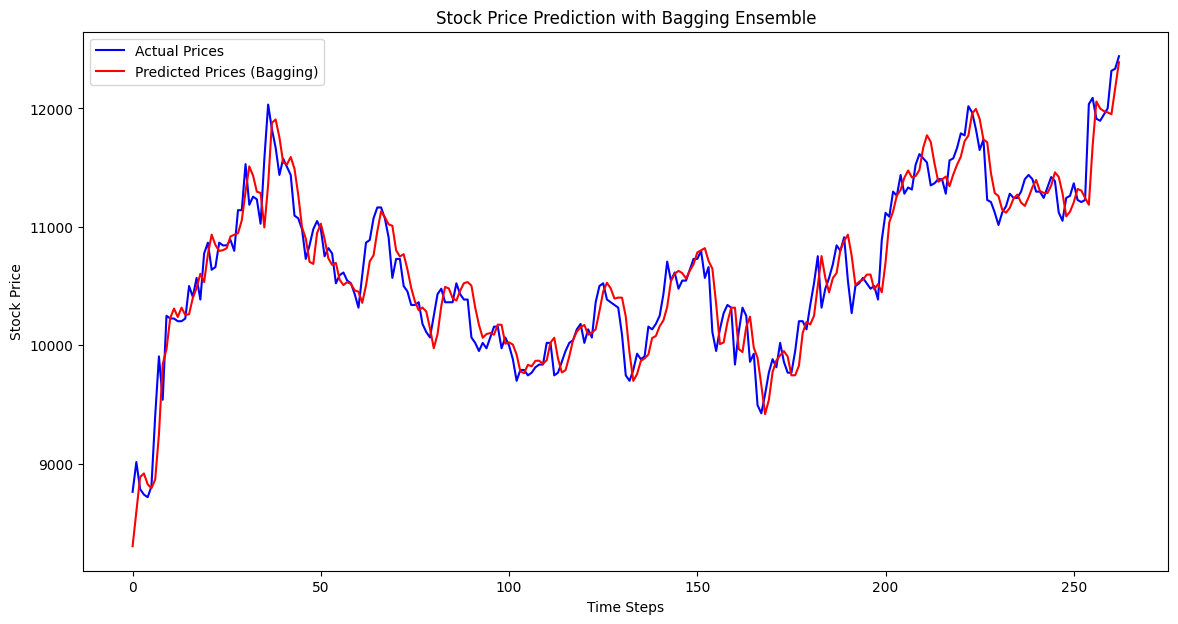

In [ ]:
# Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual Prices', color='blue')
plt.plot(bagging_predictions_inv, label='Predicted Prices (Bagging)', color='red')
plt.title('Stock Price Prediction with Bagging Ensemble')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
